In [ ]:
import os
import librosa
import pickle
import sklearn
import numpy as np
import plotly
import optuna
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

IGNORE_WARNINGS = False

if IGNORE_WARNINGS == True:
    warnings.filterwarnings('ignore')
else:
    warnings.filterwarnings('default')


Data from: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

In [2]:
train_audio_path = "C:/Users/lenovo/OneDrive/Pulpit/IB/Magisterskie/Semestr3/Głosowa Łączność z Komputerem/SpeechRecognition/SpeechRecognition/input"
commands = os.listdir(train_audio_path)
for label in commands:
    if not os.path.isdir(train_audio_path + '/' + label):
        commands.remove(label)
commands.remove('_background_noise_')  

<h1>Part 1</h1>
Finding the best value of parameters - in each trial both parameters (train_size, k) and also one additional are adjusted.

In [19]:
def Speech_Classification(train_size, k, test_size, random_data_splitting=True, extractor='nmfc', n_mfcc=None, n_mels=None, n_chroma=None,
                          order=None, win_length=None):

    classes = []
    class_size = 100
    samples = []
    labels = []
    for command in commands:
        classes.append(command)
        sample_num = 0
        for file in os.listdir(train_audio_path + '/' + command + '/'):
            sample_num += 1
            y, sr = librosa.load(train_audio_path + '/' + command + '/' + file)
            if extractor == 'nmfc':
                seq = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = n_mfcc)
            elif extractor == 'melspectrogram':
                seq = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
            elif extractor == 'chroma_stft':
                seq = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=n_chroma)
            elif extractor == 'tempogram':
                seq = librosa.feature.tempogram(y=y, sr=sr, win_length=win_length)
            elif extractor == 'poly_features':
                seq = librosa.feature.poly_features(y=y, sr=sr, order=order)

            mean_seq = []
            for feature in seq:
                mean_seq.append(np.mean(feature))
                
            samples.append(mean_seq) 
            labels.append(command)
            if sample_num == class_size:
                break

    if random_data_splitting:
        X = np.array(samples)
        y = np.array(labels)

        train_samples, test_samples, train_labels, test_labels = train_test_split(X, y, test_size=test_size/(train_size+test_size),
                                                                                  random_state=777, shuffle=True)
    else:
        train_samples = []
        train_labels = []
        test_samples = []
        test_labels = []
        for classname in classes:
            train_size_index = 0
            test_size_index = 0
            for i in range(len(labels)):
                if labels[i] == classname and train_size_index < train_size:
                    train_samples.append(samples[i])
                    train_labels.append(labels[i])
                    train_size_index += 1
                elif labels[i] == classname and test_size_index < test_size:
                    test_samples.append(samples[i])
                    test_labels.append(labels[i])
                    test_size_index += 1
                if train_size_index == train_size and test_size_index == test_size:
                    break

                
    scaler = StandardScaler()
    scaler.fit(train_samples)
    train_samples = scaler.transform(train_samples)
    test_samples = scaler.transform(test_samples)

    classifier = KNeighborsClassifier(n_neighbors = k)
    
    return classifier, train_samples, train_labels, test_samples, test_labels
    

Trial for nmfc (with tunable parameter n_mfcc)

In [ ]:
def objective(trial):
    params = {
        'n_mfcc' : trial.suggest_int('n_mfcc', 1, 100),
        'train_size' : trial.suggest_int('train_size', 1, 100),
        'k' : trial.suggest_int('k', 1, 10),
        'test_size' : 10 #Fixed
     }
    
    model, train_samples, train_labels, test_samples, test_labels = Speech_Classification(**params)
    model.fit(train_samples, train_labels)
    
    predicted_labels = model.predict(test_samples)
    quality = np.sum(test_labels == predicted_labels) / len(test_labels) * 100
    
    return quality

study = optuna.create_study(direction = 'maximize')
study.optimize(objective,n_trials = 100)

[I 2025-06-12 23:12:01,919] A new study created in memory with name: no-name-2286decf-8cec-4931-b2a4-24270c71f8e3
[I 2025-06-12 23:12:18,063] Trial 0 finished with value: 21.98581560283688 and parameters: {'n_mfcc': 26, 'train_size': 61, 'k': 7}. Best is trial 0 with value: 21.98581560283688.
[I 2025-06-12 23:12:33,813] Trial 1 finished with value: 25.986842105263158 and parameters: {'n_mfcc': 12, 'train_size': 89, 'k': 5}. Best is trial 1 with value: 25.986842105263158.
[I 2025-06-12 23:12:49,874] Trial 2 finished with value: 7.9178885630498534 and parameters: {'n_mfcc': 2, 'train_size': 78, 'k': 6}. Best is trial 1 with value: 25.986842105263158.
[I 2025-06-12 23:13:06,529] Trial 3 finished with value: 20.623916811091856 and parameters: {'n_mfcc': 10, 'train_size': 3, 'k': 1}. Best is trial 1 with value: 25.986842105263158.
[I 2025-06-12 23:13:23,690] Trial 4 finished with value: 30.25540275049116 and parameters: {'n_mfcc': 40, 'train_size': 49, 'k': 2}. Best is trial 4 with value: 3

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18328\1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

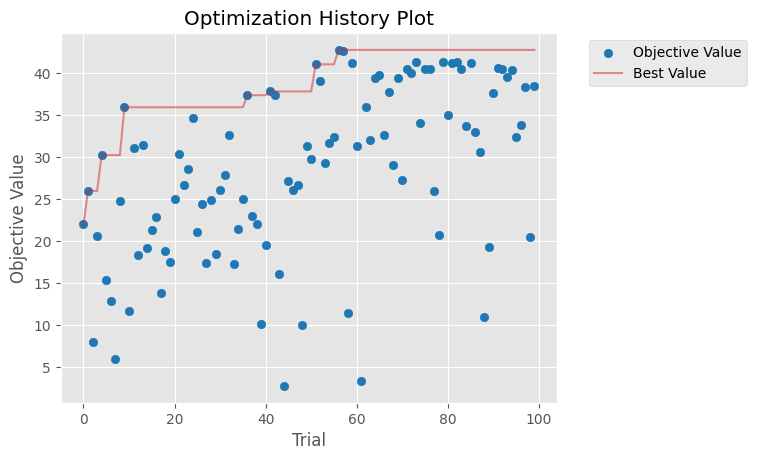

In [34]:
optuna.visualization.matplotlib.plot_optimization_history(study)

In [36]:
print("Best value: ", study.best_trial.value, "with following hyperparameters: ", study.best_trial.params)

Best value:  42.8 with following hyperparameters:  {'n_mfcc': 14, 'train_size': 30, 'k': 1}


Trial for melspectrogram (with tunable parameter n_mels)

In [44]:
def objective(trial):
    params = {
        'train_size' : trial.suggest_int('train_size', 1, 100),
        'k' : trial.suggest_int('k', 1, 10),
        'n_mels' : trial.suggest_int('n_mels', 1, 100), 
        'test_size' : 10, #Fixed
        'extractor' : 'melspectrogram'
     }
    
    model, train_samples, train_labels, test_samples, test_labels = Speech_Classification(**params)
    model.fit(train_samples, train_labels)
    
    predicted_labels = model.predict(test_samples)
    quality = np.sum(test_labels == predicted_labels) / len(test_labels) * 100
    
    return quality

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2025-06-13 15:52:34,521] A new study created in memory with name: no-name-c969a36e-1495-4989-a675-5a3c4b1334b3
[I 2025-06-13 15:52:46,205] Trial 0 finished with value: 21.597633136094675 and parameters: {'train_size': 79, 'k': 10, 'n_mels': 25}. Best is trial 0 with value: 21.597633136094675.
[I 2025-06-13 15:52:57,624] Trial 1 finished with value: 20.97902097902098 and parameters: {'train_size': 60, 'k': 8, 'n_mels': 17}. Best is trial 0 with value: 21.597633136094675.
[I 2025-06-13 15:53:12,371] Trial 2 finished with value: 15.706143128562381 and parameters: {'train_size': 9, 'k': 9, 'n_mels': 62}. Best is trial 0 with value: 21.597633136094675.
[I 2025-06-13 15:53:29,260] Trial 3 finished with value: 17.662337662337663 and parameters: {'train_size': 29, 'k': 6, 'n_mels': 94}. Best is trial 0 with value: 21.597633136094675.
[I 2025-06-13 15:53:42,520] Trial 4 finished with value: 21.46666666666667 and parameters: {'train_size': 10, 'k': 1, 'n_mels': 45}. Best is trial 0 with value

C:\Users\lenovo\AppData\Local\Temp\ipykernel_23964\1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

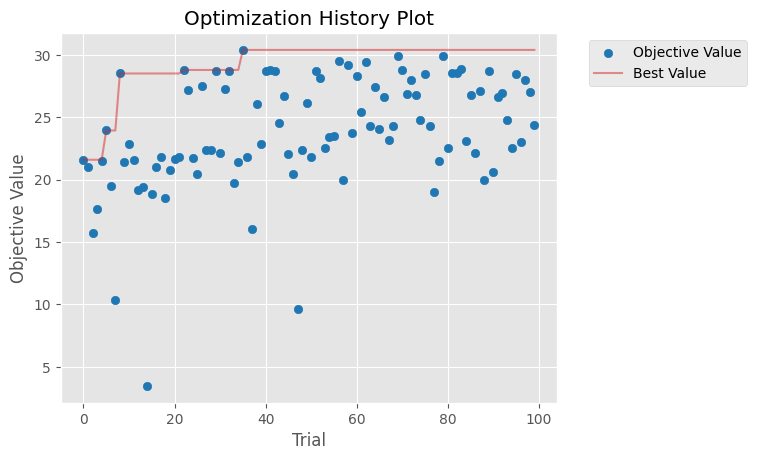

In [45]:
optuna.visualization.matplotlib.plot_optimization_history(study)

In [46]:
print("Best value: ", study.best_trial.value, "with following hyperparameters: ", study.best_trial.params)

Best value:  30.4 with following hyperparameters:  {'train_size': 70, 'k': 1, 'n_mels': 19}


Trial for chroma_stft (with tunable parameter n_chroma)

In [50]:
def objective(trial):
    params = {
        'train_size' : trial.suggest_int('train_size', 1, 100),
        'k' : trial.suggest_int('k', 1, 10),
        'n_chroma' : trial.suggest_int('n_chroma', 1, 100), 
        'test_size' : 10, #Fixed
        'extractor' : 'chroma_stft'
     }
    
    model, train_samples, train_labels, test_samples, test_labels = Speech_Classification(**params)
    model.fit(train_samples, train_labels)
    
    predicted_labels = model.predict(test_samples)
    quality = np.sum(test_labels == predicted_labels) / len(test_labels) * 100
    
    return quality

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2025-06-13 16:26:10,318] A new study created in memory with name: no-name-3cca44f4-3311-49f4-b503-0b10cadd243a
[I 2025-06-13 16:27:10,121] Trial 0 finished with value: 7.920000000000001 and parameters: {'train_size': 14, 'k': 1, 'n_chroma': 91}. Best is trial 0 with value: 7.920000000000001.
[I 2025-06-13 16:27:28,541] Trial 1 finished with value: 7.377049180327869 and parameters: {'train_size': 31, 'k': 4, 'n_chroma': 16}. Best is trial 0 with value: 7.920000000000001.
[I 2025-06-13 16:27:56,854] Trial 2 finished with value: 6.303724928366762 and parameters: {'train_size': 76, 'k': 2, 'n_chroma': 48}. Best is trial 0 with value: 7.920000000000001.
[I 2025-06-13 16:28:22,554] Trial 3 finished with value: 5.379746835443038 and parameters: {'train_size': 85, 'k': 5, 'n_chroma': 41}. Best is trial 0 with value: 7.920000000000001.
[I 2025-06-13 16:29:20,808] Trial 4 finished with value: 5.900383141762452 and parameters: {'train_size': 13, 'k': 7, 'n_chroma': 86}. Best is trial 0 with va

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

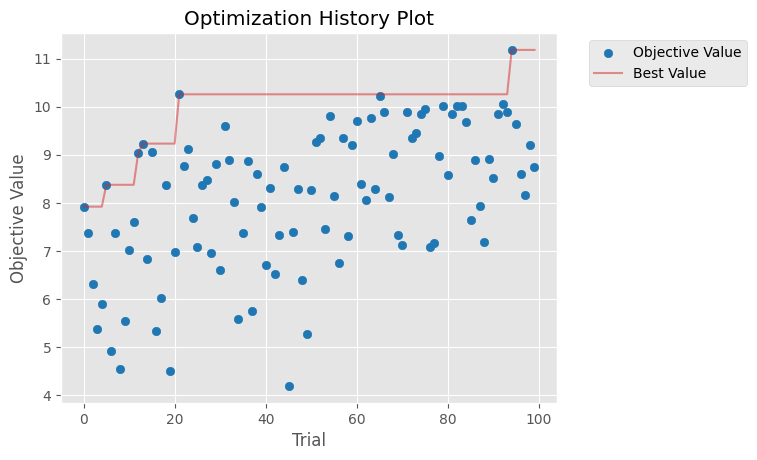

In [51]:
optuna.visualization.matplotlib.plot_optimization_history(study)

In [52]:
print("Best value: ", study.best_trial.value, "with following hyperparameters: ", study.best_trial.params)

Best value:  11.179173047473201 with following hyperparameters:  {'train_size': 36, 'k': 1, 'n_chroma': 91}


Trial for tempogram (with tunable parameter win_length)

In [16]:
def objective(trial):
    params = {
        'train_size' : trial.suggest_int('train_size', 1, 100),
        'k' : trial.suggest_int('k', 1, 10),
        'win_length' : trial.suggest_int('win_length', 100, 1000), 
        'test_size' : 10, #Fixed
        'extractor' : 'tempogram'
     }
    
    model, train_samples, train_labels, test_samples, test_labels = Speech_Classification(**params)
    model.fit(train_samples, train_labels)
    
    predicted_labels = model.predict(test_samples)
    quality = np.sum(test_labels == predicted_labels) / len(test_labels) * 100
    
    return quality

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2025-06-14 18:03:06,439] A new study created in memory with name: no-name-0eb5426d-5c07-4e39-b820-7cc43726c7c8
[I 2025-06-14 18:03:49,286] Trial 0 finished with value: 8.354430379746836 and parameters: {'train_size': 66, 'k': 2, 'win_length': 680}. Best is trial 0 with value: 8.354430379746836.
[I 2025-06-14 18:04:35,538] Trial 1 finished with value: 6.75990675990676 and parameters: {'train_size': 60, 'k': 10, 'win_length': 885}. Best is trial 0 with value: 8.354430379746836.
[I 2025-06-14 18:05:10,124] Trial 2 finished with value: 8.982035928143713 and parameters: {'train_size': 80, 'k': 9, 'win_length': 474}. Best is trial 2 with value: 8.982035928143713.
[I 2025-06-14 18:05:53,402] Trial 3 finished with value: 8.608058608058608 and parameters: {'train_size': 45, 'k': 8, 'win_length': 772}. Best is trial 2 with value: 8.982035928143713.
[I 2025-06-14 18:06:27,599] Trial 4 finished with value: 9.84 and parameters: {'train_size': 14, 'k': 2, 'win_length': 419}. Best is trial 4 with 

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

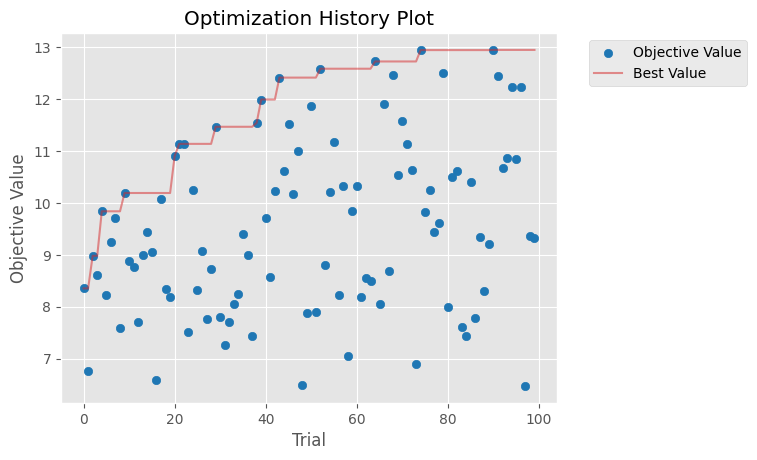

In [17]:
optuna.visualization.matplotlib.plot_optimization_history(study)

In [18]:
print("Best value: ", study.best_trial.value, "with following hyperparameters: ", study.best_trial.params)

Best value:  12.949640287769784 with following hyperparameters:  {'train_size': 98, 'k': 7, 'win_length': 101}


Trial for poly_features (with tunable parameter order)

In [20]:
def objective(trial):
    params = {
        'train_size' : trial.suggest_int('train_size', 1, 100),
        'k' : trial.suggest_int('k', 1, 10),
        'order' : trial.suggest_int('order', 0, 10), 
        'test_size' : 10, #Fixed
        'extractor' : 'poly_features'
     }
    
    model, train_samples, train_labels, test_samples, test_labels = Speech_Classification(**params)
    model.fit(train_samples, train_labels)
    
    predicted_labels = model.predict(test_samples)
    quality = np.sum(test_labels == predicted_labels) / len(test_labels) * 100
    
    return quality

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2025-06-14 19:28:30,920] A new study created in memory with name: no-name-e9e5d391-d95a-4b07-9bef-aebe6565f124
[I 2025-06-14 19:28:43,804] Trial 0 finished with value: 12.354312354312354 and parameters: {'train_size': 60, 'k': 9, 'order': 9}. Best is trial 0 with value: 12.354312354312354.
[I 2025-06-14 19:28:54,044] Trial 1 finished with value: 7.109557109557109 and parameters: {'train_size': 25, 'k': 1, 'order': 1}. Best is trial 0 with value: 12.354312354312354.
[I 2025-06-14 19:29:04,085] Trial 2 finished with value: 6.455696202531645 and parameters: {'train_size': 28, 'k': 8, 'order': 1}. Best is trial 0 with value: 12.354312354312354.
[I 2025-06-14 19:29:17,165] Trial 3 finished with value: 10.126582278481013 and parameters: {'train_size': 66, 'k': 10, 'order': 8}. Best is trial 0 with value: 12.354312354312354.
[I 2025-06-14 19:29:27,206] Trial 4 finished with value: 3.75 and parameters: {'train_size': 84, 'k': 1, 'order': 0}. Best is trial 0 with value: 12.354312354312354.
[

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

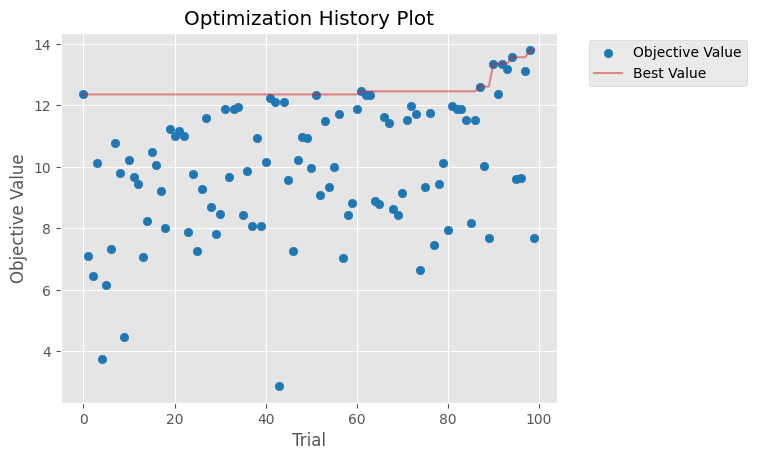

In [21]:
optuna.visualization.matplotlib.plot_optimization_history(study)

In [22]:
print("Best value: ", study.best_trial.value, "with following hyperparameters: ", study.best_trial.params)

Best value:  13.800904977375566 with following hyperparameters:  {'train_size': 58, 'k': 8, 'order': 9}


| Feature extractor | Best quality | Used parameters |
|-----------|-----------|-----------|
| mfcc | 42.80  |   {'n_mfcc': 14, 'train_size': 30, 'k': 1}    | 
| mel_spectrogram | 30.40 | {'train_size': 70, 'k': 1, 'n_mels': 19}       |
| chroma_stft | 11.18 | {'train_size': 36, 'k': 1, 'n_chroma': 91}       |
| tempogram | 12.95 | {'train_size': 98, 'k': 7, 'win_length': 101}       |
| poly_features | 13.80 |    {'train_size': 58, 'k': 8, 'order': 9}     |

<h1> Part 2 </h1>
Finding the best classification method using mfcc extractor